### Coursework coding instructions 

For the task you can choose to expand on baseline 1 or baseline 2 or add your own method. You can also expand on the pre-processing, feature extraction and data analysis

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README section in this file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

# BERT training

In [1]:
# Imports

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import torch.optim as optim
import codecs
import tqdm
import torch.nn.functional as F

In [2]:
!pip install transformers

     |████████████████████████████████| 2.2MB 8.8MB/s 
     |████████████████████████████████| 870kB 26.1MB/s 
     |████████████████████████████████| 3.3MB 44.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=a80c0ec659dfe001924fa62f7f2929386dc5ca5acaa4a50ee1c6f0f707ebf3d2
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


## Load Tokenizer from BERT

In [3]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

PRETRAINED_MODEL_NAME = "bert-base-cased"  # 指定預訓練模型

# 取得此預訓練模型所使用的 tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [4]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [5]:
vocab = tokenizer.vocab
print("字典大小：", len(vocab))

字典大小： 28996


In [6]:
wds = ['centre', 'bragg', 'Bush', 'Centre', 'We']
some_pairs = [(t, idx) for t, idx in vocab.items() if t in wds]
for pair in some_pairs:
    print(pair)

('We', 1284)
('centre', 2642)
('Centre', 2961)
('Bush', 6096)


In [7]:
# 查看tokens及其对应索引
import random
random_tokens = random.sample(list(vocab), 10)
random_ids = [vocab[t] for t in random_tokens]

print("{0:20}{1:15}".format("token", "index"))
print("-" * 25)
for t, id in zip(random_tokens, random_ids):
    print("{0:15}{1:10}".format(t, id))

token               index          
-------------------------
technical            4301
plantation          12739
Dom                 16727
labor                5530
hadn                 2018
Nicole               9628
##eera              27472
Happy                8325
ineligible          25311
Kennedy              5107


In [8]:
import os
import pandas as pd
import re

## Read data

In [9]:
# 预处理数据
def process_data(file_name):
  assert file_name in ["train", "dev", "test"]
  df = pd.read_csv(file_name + ".csv")

  #print(len(df))
  re_pat = re.compile(r'<(.*?)/>') # 正则表达式，匹配<.../>内的内容，等待被替换
  text_a, text_b = [], []

  for i in range(len(df)):
    text_a.append(re.sub(re_pat, df.loc[i, 'edit1'], df.loc[i, 'original1']))
    text_b.append(re.sub(re_pat, df.loc[i, 'edit2'], df.loc[i, 'original2']))

  df_processed = df.loc[:, ['id', 'label']]
  df_processed.insert(1, 'text_a', text_a) 
  df_processed.insert(2, 'text_b', text_b)

  # 去除label=0数据
  #if file_name in ["train", "dev"]:
  df_processed = df_processed[~df.label.isin([0])]
  # 所有label = label - 1
  df_processed['label'] = df.label.apply(lambda x: x - 1)

  #print(df_processed.head(5))
  df_processed.to_csv(file_name + "_processed.csv", index=False)
  print("Finished writing to {}_processed.csv".format(file_name))



files = ["train", "dev", "test"]
for f in files:
  process_data(f)

Finished writing to train_processed.csv
Finished writing to dev_processed.csv
Finished writing to test_processed.csv


In [10]:
# 数据可视化
df_train = pd.read_csv("train_processed.csv").fillna("")
df_text = df_train.loc[:, 'text_a']
text = df_text.values
#print(df_text)

texts = []
for i in range(len(text)):
  texts.append(len(text[i].split(' ')))

labels = df_train.loc[:, 'label'].values
texts = np.array(texts)

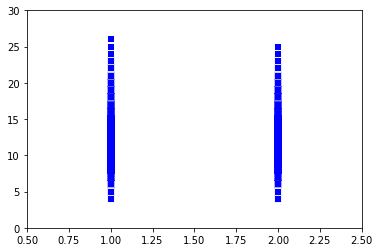

In [43]:
import matplotlib.pyplot as plt

# axis设置坐标轴的范围
plt.axis([0.5, 2.5, 0, 30])
# x为x轴中坐标x的值，y为y轴中坐标y的值，x与y都是长度相同的数组序列，color为点的颜色，marker为散点的形状，
# linewidth为点的大小
plt.scatter(labels + 1, texts, color="blue", marker=",", linewidth=0.01)
plt.show()

In [11]:
["""

def iszero(x):
  if x is 0:
    x = 1
  return x


file_name = "test"
df = pd.read_csv(file_name + ".csv")
#print(len(df))
#re_pat = re.compile(r'<(.*?)/>') # 正则表达式，匹配<.../>内的内容，等待被替换
#text_a, text_b = [], []

#for i in range(len(df)):
#  text_a.append(re.sub(re_pat, df.loc[i, 'edit1'], df.loc[i, 'original1']))
#  text_b.append(re.sub(re_pat, df.loc[i, 'edit2'], df.loc[i, 'original2']))

df_processed = df.loc[:, ['id', 'label']]
df_processed['label'] = df.label.apply(iszero)


df_processed.columns = ['id', 'pred']
#df_processed.insert(1, 'text_a', text_a) 
#df_processed.insert(2, 'text_b', text_b)
#print(df_processed.head(5))
df_processed.to_csv("task-2-output.csv", index=False)
print("Finished writing to task-2-output.csv".format(file_name))

"""

'\n\ndef iszero(x):\n  if x is 0:\n    x = 1\n  return x\n\n\nfile_name = "test"\ndf = pd.read_csv(file_name + ".csv")\n#print(len(df))\n#re_pat = re.compile(r\'<(.*?)/>\') # 正则表达式，匹配<.../>内的内容，等待被替换\n#text_a, text_b = [], []\n\n#for i in range(len(df)):\n#  text_a.append(re.sub(re_pat, df.loc[i, \'edit1\'], df.loc[i, \'original1\']))\n#  text_b.append(re.sub(re_pat, df.loc[i, \'edit2\'], df.loc[i, \'original2\']))\n\ndf_processed = df.loc[:, [\'id\', \'label\']]\ndf_processed[\'label\'] = df.label.apply(iszero)\n\n\ndf_processed.columns = [\'id\', \'pred\']\n#df_processed.insert(1, \'text_a\', text_a) \n#df_processed.insert(2, \'text_b\', text_b)\n#print(df_processed.head(5))\ndf_processed.to_csv("task-2-output.csv", index=False)\nprint("Finished writing to task-2-output.csv".format(file_name))\n\n'

## Generating Dataset, DataLoader

In [13]:
"""
實作一個可以用來讀取訓練 / 測試集的 Dataset。
此 Dataset 每次將 tsv 裡的一筆成對句子轉換成 BERT 相容的格式，並回傳 3 個 tensors：
- tokens_tensor：兩個句子合併後的索引序列，包含 [CLS] 與 [SEP]
- segments_tensor：可以用來識別兩個句子界限的 binary tensor
- label_tensor：將分類標籤轉換成類別索引的 tensor, 如果是測試集則回傳 None
"""
from torch.utils.data import Dataset

class Task2Dataset(Dataset):
  # 讀取前處理後的 dsv 檔並初始化一些參數
  def __init__(self, mode, tokenizer):
    assert mode in ["train", "dev", "test"] 
    self.mode = mode
    # 大數據你會需要用 iterator=True
    self.df = pd.read_csv(mode + "_processed.csv").fillna("")
    self.len = len(self.df)
    self.tokenizer = tokenizer  # 我們將使用 BERT tokenizer
  
  # 定義回傳一筆訓練 / 測試數據的函式
  def __getitem__(self, idx):

    _, text_a, text_b, label = self.df.iloc[idx, :].values
      
    """  
    len_a = len(text_a)
    len_b = len(text_b)
    # 将两句话转成 [CLS]+text_a+[SEP]+ext_b+[SEP]对应的id
    combined_text = self.tokenizer.encode(text_a, text_b, add_special_tokens=True)
    tokens_tensor = torch.tensor(combined_text)
    """
    # 建立第一個句子的 BERT tokens 並加入起始符号[CLS] 分隔符號 [SEP]
    word_pieces = ["[CLS]"]
    tokens_a = self.tokenizer.tokenize(text_a)
    word_pieces += tokens_a + ["[SEP]"]
    len_a = len(word_pieces)
    
    # 第二個句子的 BERT tokens 並加入分隔符號 [SEP]
    tokens_b = self.tokenizer.tokenize(text_b)
    word_pieces += tokens_b + ["[SEP]"]
    len_b = len(word_pieces) - len_a

    # 將整個 token 序列轉換成索引序列
    ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
    tokens_tensor = torch.tensor(ids) 
    
    # 將第一句包含 [SEP] 的 token 位置設為 0，其他為 1 表示第二句
    segments_tensor = torch.tensor([0] * len_a + [1] * len_b, 
                                    dtype=torch.long)
    label_tensor = torch.tensor(label)
    
    return (tokens_tensor, segments_tensor, label_tensor)
  
  def __len__(self):
    return self.len
    
    
# 初始化一個專門讀取訓練樣本的 Dataset，使用bert-base-cased 斷詞
trainset = Task2Dataset("train", tokenizer=tokenizer)
devset = Task2Dataset("dev", tokenizer=tokenizer)
testset = Task2Dataset("test", tokenizer=tokenizer)

In [15]:
# 選擇第一個樣本
sample_idx = 4

# 將原始文本拿出做比較
_, text_a, text_b, label = trainset.df.iloc[sample_idx].values

# 利用剛剛建立的 Dataset 取出轉換後的 id tensors
tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

# 將 tokens_tensor 還原成文本
tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)

#print("tokens: ", tokens)

# 渲染前後差異，毫無反應就是個 print。可以直接看輸出結果
print(f"""[initial text]
text 1：{text_a}
text 2：{text_b}
label  ：{label + 1}

--------------------

[Dataset returns]

tokens_tensor  ：{tokens_tensor} shape:{tokens_tensor.shape}

segments_tensor：{segments_tensor} shape:{segments_tensor.shape}

label_tensor   ：{label_tensor + 1}

--------------------

[tokens_tensors to combined text]
{combined_text}
""")

[initial text]
text 1：" System safeguards are lacking " , quote following a Tesla 's flight during autopilot
text 2：" System safeguards are lacking " , quote following a Tesla 's explosion during autopilot
label  ：2

--------------------

[Dataset returns]

tokens_tensor  ：tensor([  101,   107,  3910,  2914, 12188,  1116,  1132, 11744,   107,   117,
        15882,  1378,   170, 12008, 26597,   112,   188,  3043,  1219, 12365,
         8508,  7841,   102,   107,  3910,  2914, 12188,  1116,  1132, 11744,
          107,   117, 15882,  1378,   170, 12008, 26597,   112,   188,  7552,
         1219, 12365,  8508,  7841,   102]) shape:torch.Size([45])

segments_tensor：tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) shape:torch.Size([45])

label_tensor   ：2

--------------------

[tokens_tensors to combined text]
[CLS] " System safe ##guard ##s are lacking " , quote following a Te ##sla ' s 

In [16]:
"""
實作可以一次回傳一個 mini-batch 的 DataLoader
這個 DataLoader 吃我們上面定義的 `Task2Dataset`，
回傳訓練 BERT 時會需要的 4 個 tensors：
- tokens_tensors  : (batch_size, max_seq_len_in_batch)
- segments_tensors: (batch_size, max_seq_len_in_batch)
- masks_tensors   : (batch_size, max_seq_len_in_batch)
- label_ids       : (batch_size)
"""

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# 這個函式的輸入 `samples` 是一個 list，裡頭的每個 element 都是
# 剛剛定義的 `Task2Dataset` 回傳的一個樣本，每個樣本都包含 3 tensors：
# - tokens_tensor
# - segments_tensor
# - label_tensor
# 它會對兩個 tokens_tensor 与 segments_tensor 作 zero padding，並產生前面說明過的 masks_tensors
def collate_fn_padd(samples):

  tokens_tensors = [s[0] for s in samples]
  segments_tensors = [s[1] for s in samples]
  
  label_ids = torch.stack([s[2] for s in samples])
  
  # zero pad 到同一序列長度
  tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
  segments_tensors = pad_sequence(segments_tensors, batch_first=True)
  
  # attention masks，將 tokens_tensors 裡頭不為 zero padding
  # 的位置設為 1 讓 BERT 只關注這些位置的 tokens
  masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
  masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
  
  return tokens_tensors, segments_tensors, masks_tensors, label_ids


# 初始化一個每次回傳 64 個訓練樣本的 DataLoader
# 利用 `collate_fn` 將 list of samples 合併成一個 mini-batch 是關鍵
BATCH_SIZE = 32
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, 
                         collate_fn=collate_fn_padd)
devloader = DataLoader(devset, batch_size=BATCH_SIZE, 
                         collate_fn=collate_fn_padd)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, 
                         collate_fn=collate_fn_padd)

In [17]:
# 有了可以回傳 mini-batch 的 DataLoader 後，讓我們馬上拿出一個 batch 看看

data = next(iter(trainloader))

tokens_tensors, segments_tensors, \
    masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")


tokens_tensors.shape   = torch.Size([32, 53]) 
tensor([[  101,   107,  9066,  ...,     0,     0,     0],
        [  101,   107,   146,  ...,     0,     0,     0],
        [  101,   107,   146,  ...,     0,     0,     0],
        ...,
        [  101,   112,  2117,  ...,     0,     0,     0],
        [  101,   112, 20053,  ...,     0,     0,     0],
        [  101,   112, 20053,  ...,     0,     0,     0]])
------------------------
segments_tensors.shape = torch.Size([32, 53])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
------------------------
masks_tensors.shape    = torch.Size([32, 53])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
------------

In [18]:
print(torch.cuda.is_available())

True


## Load model from BERT



In [19]:
# 載入一個可以做中文多分類任務的模型，n_class = 2
from transformers import BertForSequenceClassification

NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)
model.to(device)
print("Model initialised.")

# high-level 顯示此模型裡的 modules
print("""
name            module
----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Model initialised.

name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=2, bias=True)


In [20]:
model.config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.5.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [21]:
def get_learnable_params(module):
    return [p for p in module.parameters() if p.requires_grad]
     
model_params = get_learnable_params(model)
clf_params = get_learnable_params(model.classifier)

print(f"""
整個分類模型的參數量：{sum(p.numel() for p in model_params)}
線性分類器的參數量：{sum(p.numel() for p in clf_params)}
""")


整個分類模型的參數量：108311810
線性分類器的參數量：1538



## Define eval() and train()

In [25]:
"""
定義一個可以針對特定 DataLoader 取得模型預測結果以及分類準確度的函式

在將 `tokens`、`segments_tensors` 等 tensors
丟入模型時，強力建議指定每個 tensor 對應的參數名稱，以避免 HuggingFace
更新 repo 程式碼並改變參數順序時影響到我們的結果。
"""
def eval(data_iter, model):
  model.eval()
  predictions = None
  targets = None
  total_correct = 0
  total_observation = 0
  total_loss = 0

  with torch.no_grad():
    # 遍巡整個資料集
    for batch in data_iter:
      # batch就是函数collate_fn_padd的返回值
      tokens_tensors, segments_tensors, masks_tensors, labels = batch
      tokens_tensors, segments_tensors, masks_tensors, labels = tokens_tensors.to(device), \
          segments_tensors.to(device), masks_tensors.to(device), labels.to(device)

      # for BERT:
      # test的时候不提供labels， 所以没有loss
      outputs = model(input_ids=tokens_tensors, 
                token_type_ids=segments_tensors, 
                attention_mask=masks_tensors,
                labels=labels)
      
      loss = outputs.loss    # loss就是损失函数生成的loss, 这个return值只有在提供label的情况下才会生成
      logits = outputs.logits  # (batch_size, config.num_labels)， Classification scores (before SoftMax).

      _, pred = torch.max(logits, 1)
      
      total_observation += labels.size(0)
      total_correct += (pred == labels).sum().item()
      total_loss += loss.item()

      # 將當前 batch 記錄下來
      if predictions is None:
        predictions = pred
      else:
        predictions = torch.cat((predictions, pred))

      if targets is None:
        targets = labels
      else:
        targets = torch.cat((targets, labels))
    
  #acc = correct / total
  return total_loss/total_observation, total_correct/total_observation, predictions, targets

In [24]:
# first see the model performance on the training set  before training 
_, acc, _, _ = eval(trainloader, model)
print("classification acc: {:.2f}%".format(acc*100))

classification acc: 49.92%


In [34]:
def train(train_iter, dev_iter, model, number_epoch):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    print("Training model.")

    for epoch in range(1, number_epoch + 1):
        # 訓練模式
        model.train()

        total_loss = 0
        total_correct = 0
        total_observations = 0  # Observations used for training so far

        for batch in train_iter:
            # batch就是函数collate_fn_padd的返回值
            tokens_tensors, segments_tensors, masks_tensors, labels = batch
            tokens_tensors, segments_tensors, masks_tensors, labels = tokens_tensors.to(device), \
            segments_tensors.to(device), masks_tensors.to(device), labels.to(device)

            
            # 將參數梯度歸零
            optimizer.zero_grad()

            # for BERT:
            # forward pass
            outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

            loss = outputs.loss    # loss就是损失函数生成的loss, 这个return值只有在提供label的情况下才会生成
            logits = outputs.logits  # (batch_size, config.num_labels)， Classification scores (before SoftMax).

            _, pred = torch.max(logits, 1)


            total_observations += labels.size(0)
            total_correct += (pred == labels).sum().item()
            total_loss += loss.item()


            #predictions = model(feature).squeeze(1)

            #loss = loss_fn(predictions, target)


            # backward and update the gradient
            loss.backward()
            optimizer.step()
          

            #epoch_loss += loss.item() * target.shape[0]
            #total_correct += correct

        valid_loss, valid_acc, __, __ = eval(dev_iter, model)

        total_loss, total_acc = total_loss / total_observations, total_correct / total_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {total_loss:.2f} | Train Accuracy: {total_acc:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. Accuracy: {valid_acc:.2f} |')


## Train the model

In [40]:
# 使用 Adam Optim 更新整個分類模型的參數
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
epochs = 8 # 幸運數字

In [41]:
%%time
train(trainloader, devloader, model, epochs)

Training model.
| Epoch: 01 | Train Loss: 0.01 | Train Accuracy: 0.88 |         Val. Loss: 0.04 | Val. Accuracy: 0.54 |
| Epoch: 02 | Train Loss: 0.01 | Train Accuracy: 0.91 |         Val. Loss: 0.05 | Val. Accuracy: 0.53 |
| Epoch: 03 | Train Loss: 0.01 | Train Accuracy: 0.93 |         Val. Loss: 0.04 | Val. Accuracy: 0.56 |
| Epoch: 04 | Train Loss: 0.01 | Train Accuracy: 0.93 |         Val. Loss: 0.04 | Val. Accuracy: 0.58 |
| Epoch: 05 | Train Loss: 0.01 | Train Accuracy: 0.93 |         Val. Loss: 0.04 | Val. Accuracy: 0.58 |
| Epoch: 06 | Train Loss: 0.00 | Train Accuracy: 0.95 |         Val. Loss: 0.05 | Val. Accuracy: 0.57 |
| Epoch: 07 | Train Loss: 0.00 | Train Accuracy: 0.96 |         Val. Loss: 0.05 | Val. Accuracy: 0.58 |
| Epoch: 08 | Train Loss: 0.00 | Train Accuracy: 0.97 |         Val. Loss: 0.05 | Val. Accuracy: 0.59 |
CPU times: user 5min 13s, sys: 2min 14s, total: 7min 28s
Wall time: 7min 28s


## Get the result on the test set

In [44]:
%%time
_, acc, predictions, _ = eval(testloader, model)

print('Test ...')
print('Test_acc={}'.format(acc))

# 生成 繳交檔案
df = pd.DataFrame({"pred": predictions.tolist()})
df_pred = pd.concat([testset.df.loc[:, ["id"]], 
                          df.loc[:, 'pred']], axis=1)
df_pred['pred'] = df.pred.apply(lambda x: x + 1)
df_pred.to_csv('task-2-output.csv', index=False)
df_pred.head()

Test ...
Test_acc=0.5924657534246576
CPU times: user 4.62 s, sys: 1.63 s, total: 6.26 s
Wall time: 6.24 s
